<a href="https://colab.research.google.com/github/gaditi123/PRML-project/blob/main/Pill_Recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip uninstall scikit-learn -y
!pip install -U scikit-learn

Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 22.3MB 1.6MB/s 


In [27]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, recall_score, precision_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud, STOPWORDS

In [137]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
train = pd.read_csv('drive/My Drive/drugsComTrain_raw.csv')
test = pd.read_csv('drive/My Drive/drugsComTest_raw.csv')
# train = pd.read_csv('drive/My Drive/drugsCom_raw/drugsComTrain_raw.csv')
# test = pd.read_csv('drive/My Drive/drugsCom_raw/drugsComTest_raw.csv')
# getting the shapes
print("Shape of train :", train.shape)
print("Shape of test :", test.shape)

Mounted at /content/drive
Shape of train : (161297, 7)
Shape of test : (53766, 7)


In [138]:
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [139]:
test.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,163740,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,28-Feb-12,22
1,206473,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,17-May-09,17
2,159672,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,29-Sep-17,3
3,39293,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,5-Mar-17,35
4,97768,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,22-Oct-15,4


In [140]:
# as both the dataset contains same columns we can combine them for better analysis
data = pd.concat([train, test])

# checking the shape
data.shape

(215063, 7)

# Visulisation

In [143]:
def listToString(s): 
    str1 = " " 
    return (str1.join(s))

In [144]:
# textString=listToString(data["condition"])
# wordcloud = WordCloud(max_words = 100, width = 1500, height = 1000, random_state=1, background_color='navy', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(textString)

# plt.title('Most Common Conditions among the Patients', fontsize = 30)
# print(wordcloud)
# plt.axis('off')
# plt.imshow(wordcloud)
# plt.show()

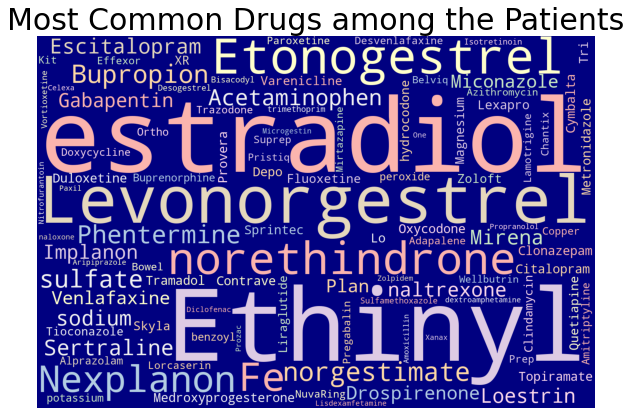

In [150]:
stopwords = set(STOPWORDS)
textString=listToString(data["drugName"])
wordcloud = WordCloud(max_words = 100, width = 1500, height = 1000, random_state=1, background_color='navy', colormap='Pastel1', collocations=False, stopwords = STOPWORDS).generate(textString)

plt.title('Most Common Drugs among the Patients', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

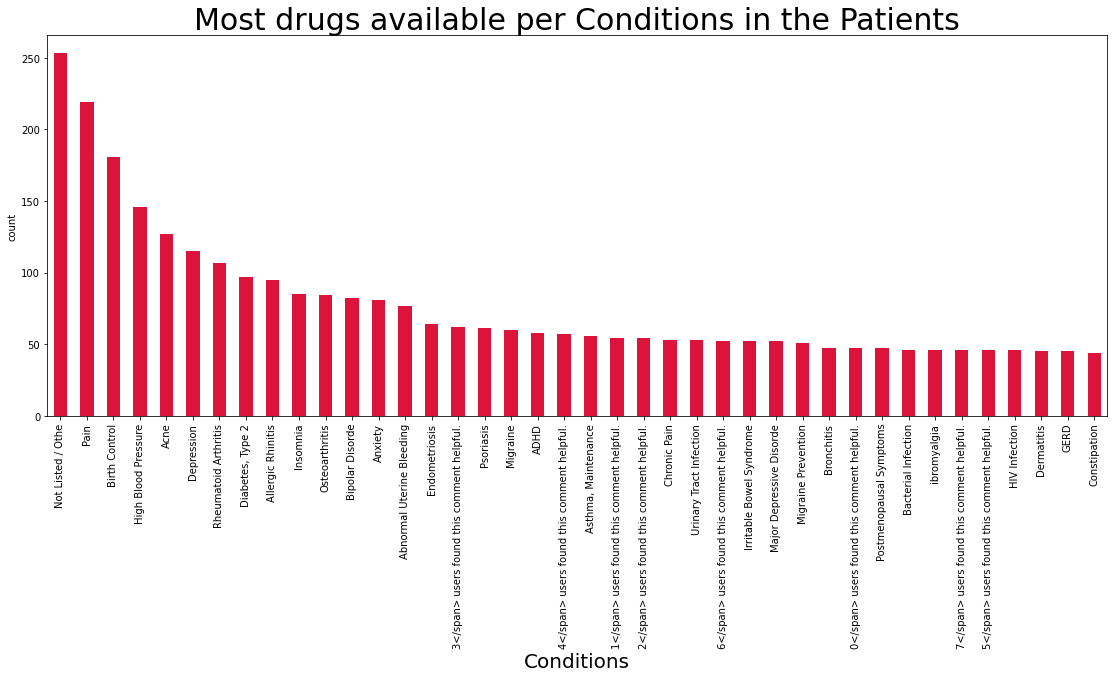

In [146]:
data.groupby(['condition'])['drugName'].nunique().sort_values(ascending = False).head(40).plot.bar(figsize = (19, 7), color = 'crimson')
plt.title('Most drugs available per Conditions in the Patients', fontsize = 30)
plt.xlabel('Conditions', fontsize = 20)
plt.ylabel('count')
plt.show()

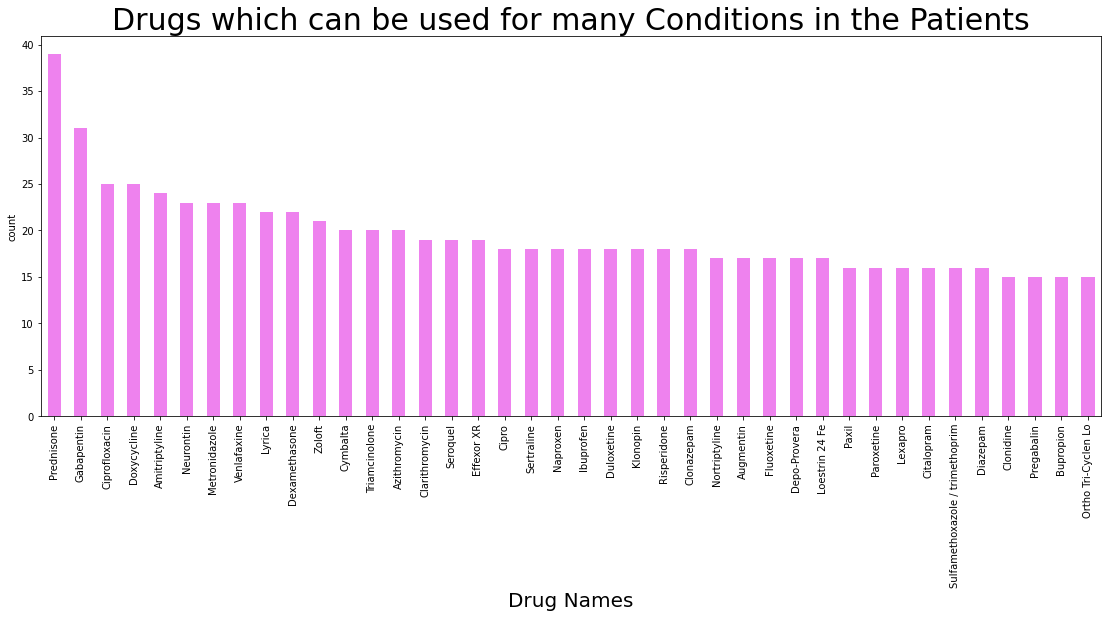

In [147]:
# checking the most popular drugs per conditions

data.groupby(['drugName'])['condition'].nunique().sort_values(ascending = False).head(40).plot.bar(figsize = (19, 7), color = 'violet')
plt.title('Drugs which can be used for many Conditions in the Patients', fontsize = 30)
plt.xlabel('Drug Names', fontsize = 20)
plt.ylabel('count')
plt.show()

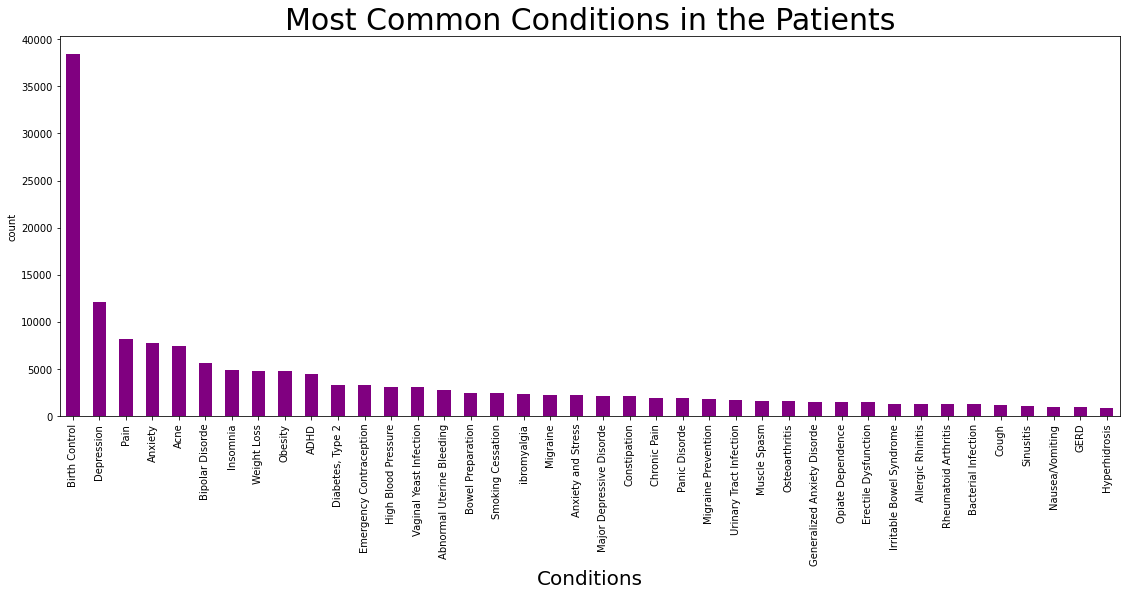

In [148]:
# checking the different types of conditions patients

data['condition'].value_counts().head(40).plot.bar(figsize = (19, 7), color = 'purple')
plt.title('Most Common Conditions in the Patients', fontsize = 30)
plt.xlabel('Conditions', fontsize = 20)
plt.ylabel('count')
plt.show()

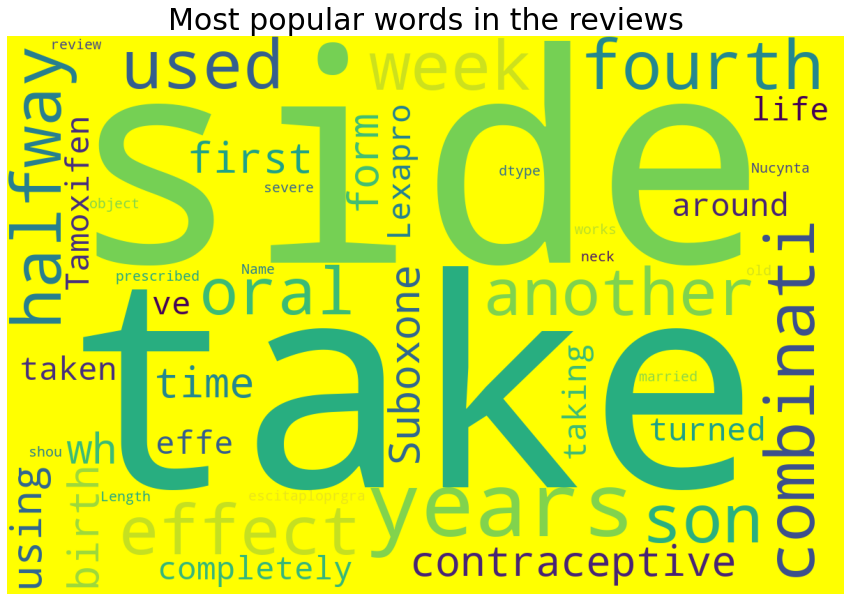

In [151]:
wordcloud = WordCloud(background_color = 'yellow', stopwords = stopwords, width = 1200, height = 800).generate(str(data['review']))

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most popular words in the reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

In [152]:
data['rating'].value_counts()

10    68005
9     36708
1     28918
8     25046
7     12547
5     10723
2      9265
3      8718
6      8462
4      6671
Name: rating, dtype: int64

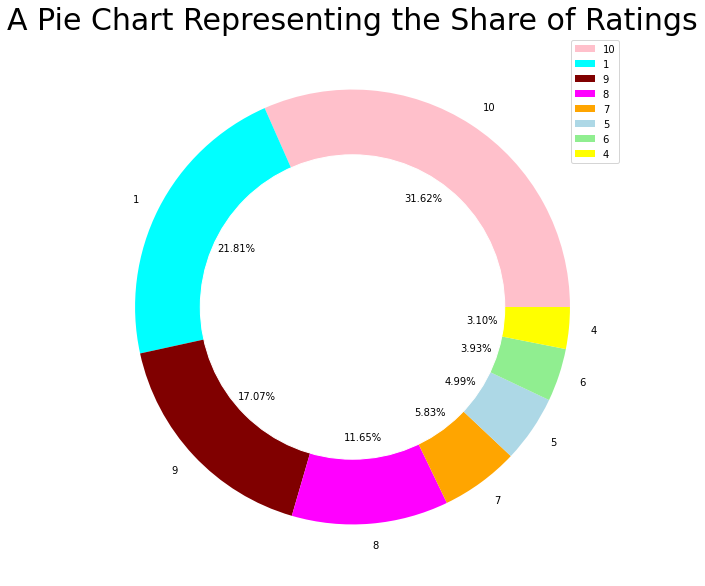

In [153]:
size = [68005, 46901, 36708, 25046, 12547, 10723, 8462, 6671]
colors = ['pink', 'cyan', 'maroon',  'magenta', 'orange', 'lightblue', 'lightgreen', 'yellow']
labels = "10", "1", "9", "8", "7", "5", "6", "4"

my_circle = plt.Circle((0, 0), 0.7, color = 'white')

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels, autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Share of Ratings', fontsize = 30)
p = plt.gcf()
plt.gca().add_artist(my_circle)
plt.legend()
plt.show()

Add review sentiment column which acts as target variable. It gives a (good,bad)-(1,0) value based on rating of the drug

In [154]:
# feature engineering 
# let's make a new column review sentiment 

data.loc[(data['rating'] >= 7), 'Review_Sentiment'] = 2
data.loc[(data['rating']== 5), 'Review_Sentiment'] = 1
data.loc[(data['rating']== 6), 'Review_Sentiment'] = 1
data.loc[(data['rating']<5), 'Review_Sentiment'] = 0
data['Review_Sentiment'].value_counts()

2.0    142306
0.0     53572
1.0     19185
Name: Review_Sentiment, dtype: int64

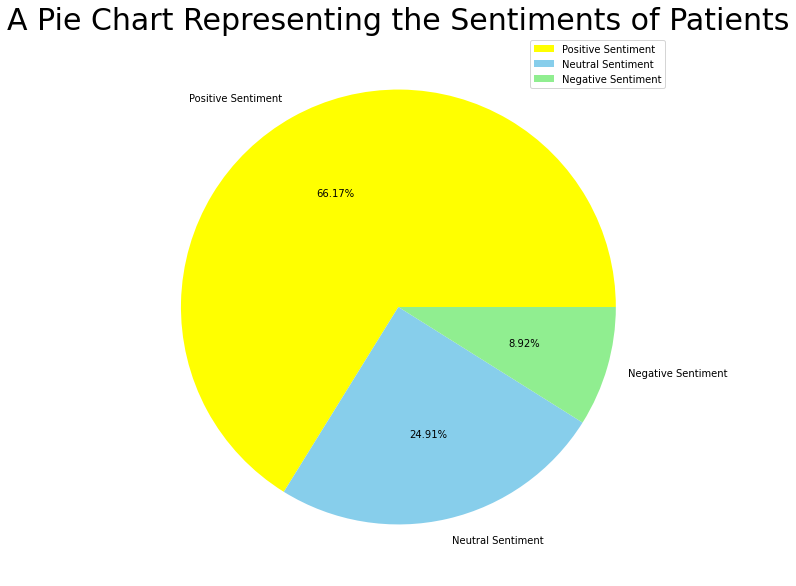

In [155]:
size = [142306,53572,19185]
colors = ['yellow', 'skyblue','lightgreen']
labels = "Positive Sentiment","Neutral Sentiment","Negative Sentiment"
#explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (10, 10)
plt.pie(size, colors = colors, labels = labels,  autopct = '%.2f%%')
plt.axis('off')
plt.title('A Pie Chart Representing the Sentiments of Patients', fontsize = 30)
plt.legend()
plt.show()

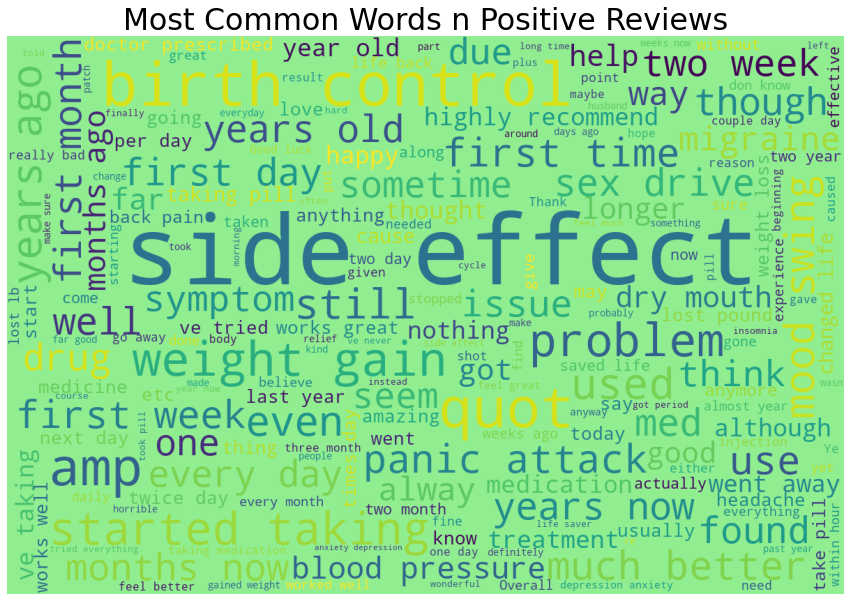

In [156]:
# making Words cloud for the postive sentiments

positive_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 2]])

wordcloud = WordCloud(background_color = 'lightgreen', stopwords = stopwords, width = 1200, height = 800).generate(positive_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words n Positive Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

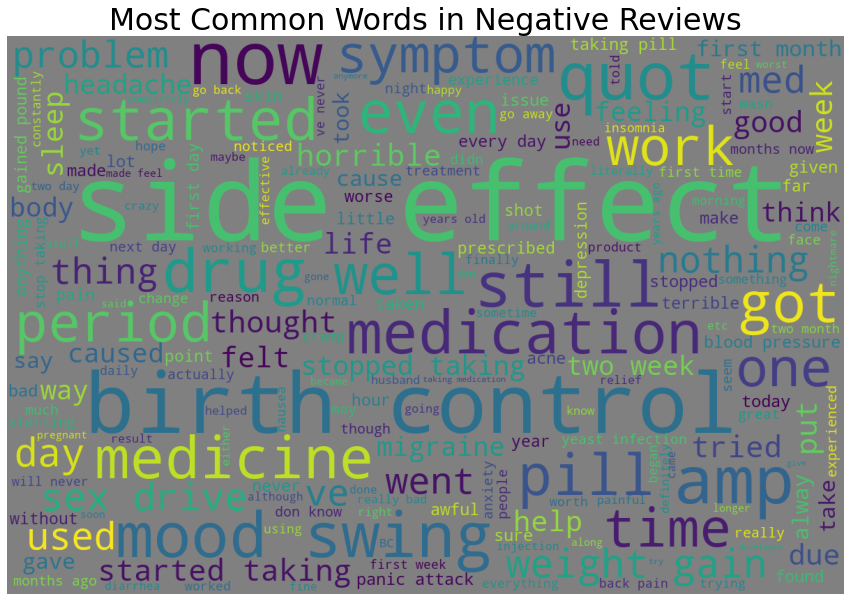

In [157]:
negative_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 0]])
wordcloud = WordCloud(background_color = 'grey', stopwords = stopwords, width = 1200, height = 800).generate(negative_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words in Negative Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

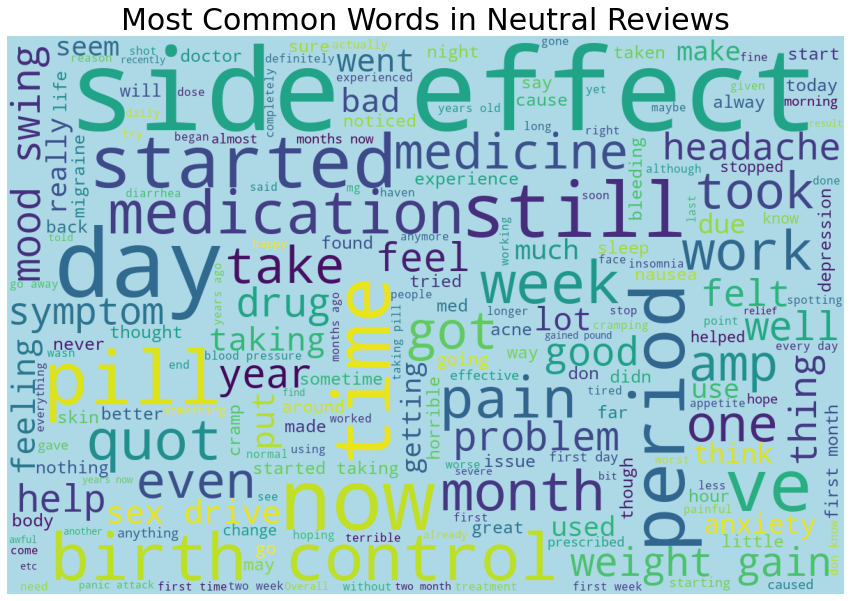

In [158]:
neutral_sentiments = " ".join([text for text in data['review'][data['Review_Sentiment'] == 1]])
wordcloud = WordCloud(background_color = 'lightblue', stopwords = stopwords, width = 1200, height = 800).generate(neutral_sentiments)

plt.rcParams['figure.figsize'] = (15, 15)
plt.title('Most Common Words in Neutral Reviews', fontsize = 30)
print(wordcloud)
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

Extracting year,month and day from the date column

In [159]:
# converting the date into datetime format
data['date'] = pd.to_datetime(data['date'], errors = 'coerce')

# now extracting year from date
data['Year'] = data['date'].dt.year

# extracting the month from the date
data['month'] = data['date'].dt.month

# extracting the days from the date
data['day'] = data['date'].dt.day

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


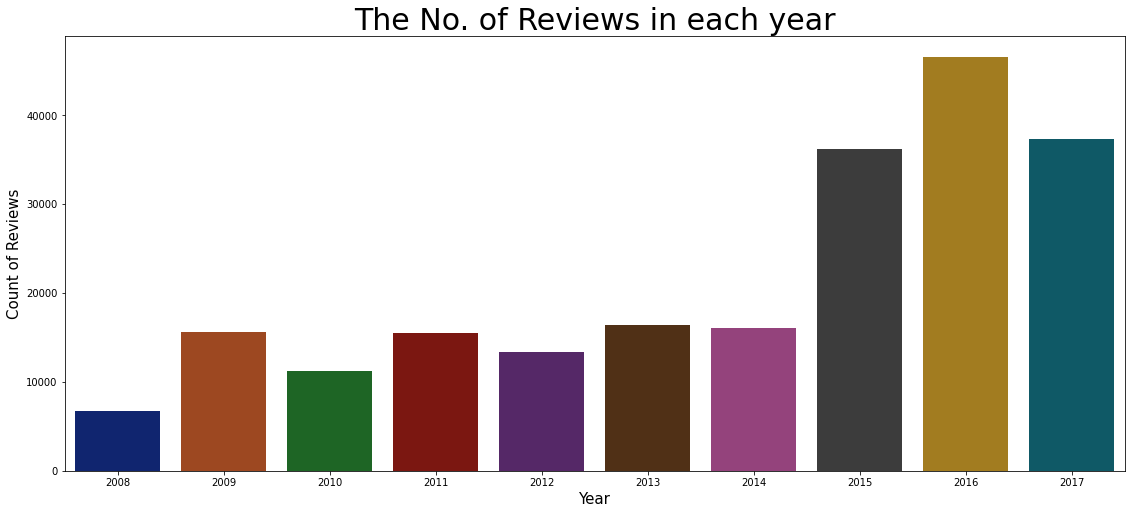

In [160]:
# looking at the no. of reviews in each of the year

plt.rcParams['figure.figsize'] = (19, 8)
sns.countplot(data['Year'], palette ='dark')
plt.title('The No. of Reviews in each year', fontsize = 30)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count of Reviews', fontsize = 15)
plt.show()

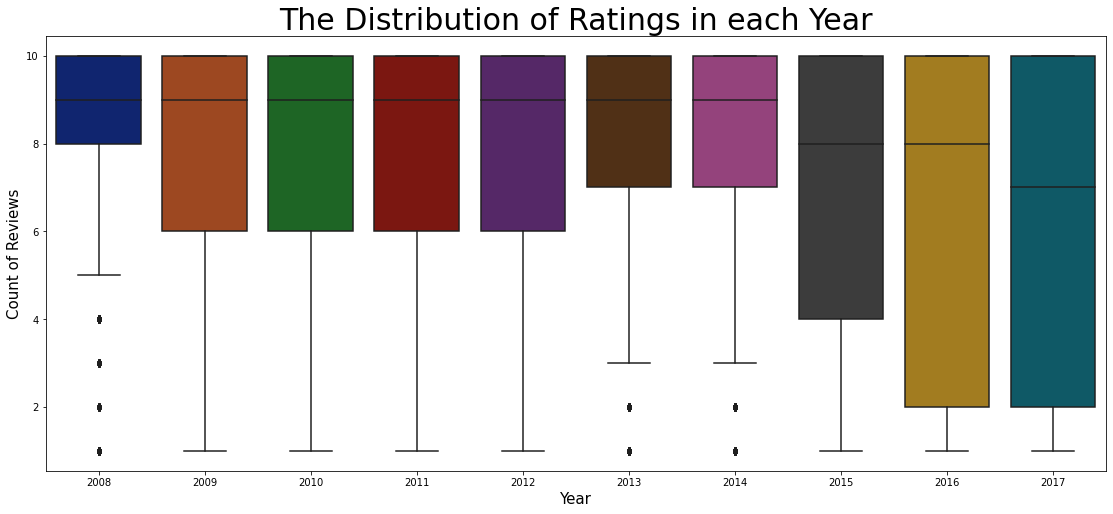

In [161]:
# looking at the no. of ratings in each of the year

plt.rcParams['figure.figsize'] = (19, 8)
sns.boxplot(x = data['Year'], y = data['rating'], palette ='dark')
plt.title('The Distribution of Ratings in each Year', fontsize = 30)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Count of Reviews', fontsize = 15)
plt.show()

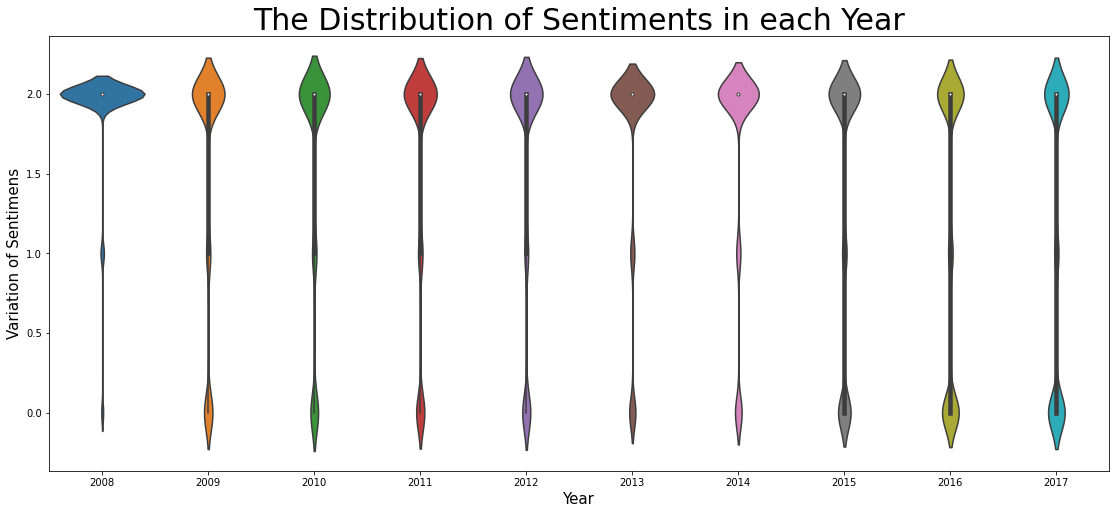

In [162]:
# looking at the no. of ratings in each of the year

plt.rcParams['figure.figsize'] = (19, 8)
sns.violinplot(x = data['Year'], y = data['Review_Sentiment'])
plt.title('The Distribution of Sentiments in each Year', fontsize = 30)
plt.xlabel('Year', fontsize = 15)
plt.ylabel('Variation of Sentimens', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


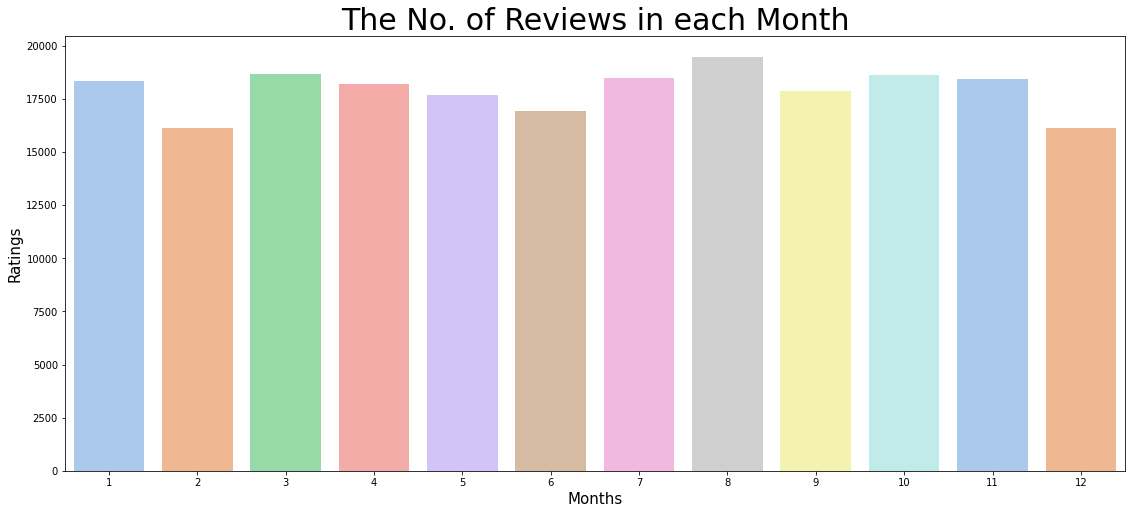

In [163]:
# looking at the no. of reviews in each of the months

plt.rcParams['figure.figsize'] = (19, 8)
sns.countplot(data['month'], palette ='pastel')
plt.title('The No. of Reviews in each Month', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Ratings', fontsize = 15)
plt.show()

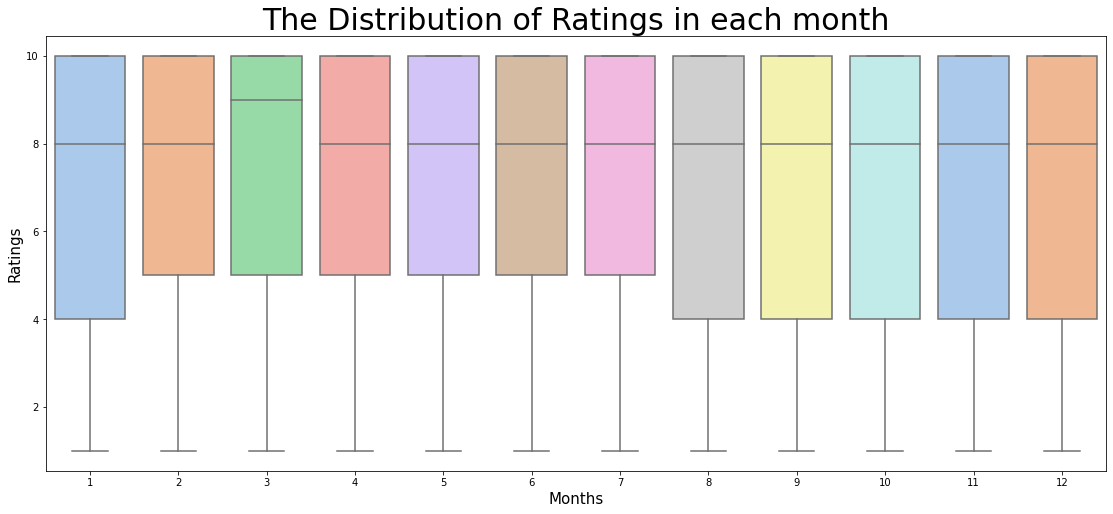

In [164]:
# looking at the no. of ratings in each of the month

plt.rcParams['figure.figsize'] = (19, 8)
sns.boxplot(x = data['month'], y = data['rating'], palette ='pastel')
plt.title('The Distribution of Ratings in each month', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Ratings', fontsize = 15)
plt.show()

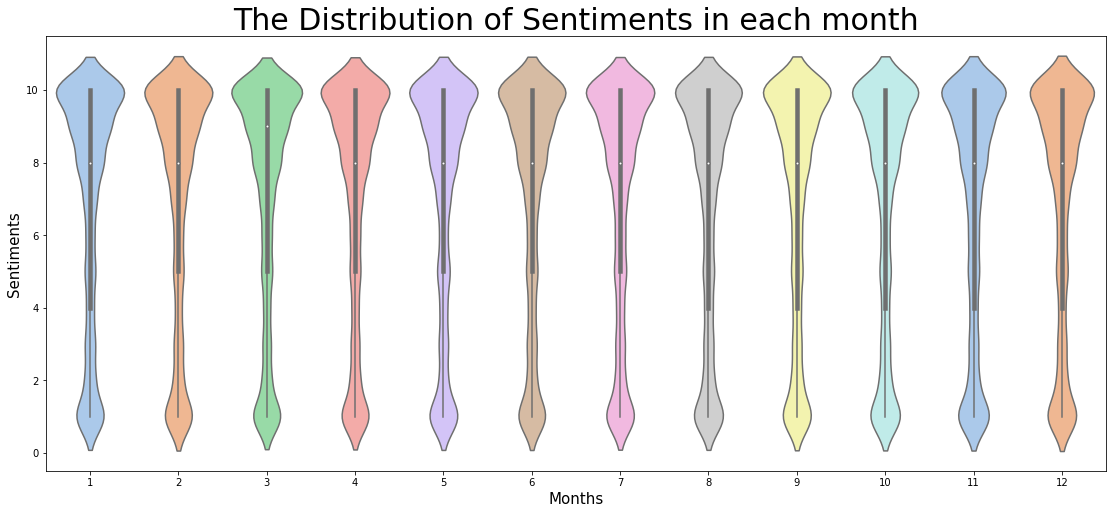

In [165]:
# looking at the no. of ratings in each of the month

plt.rcParams['figure.figsize'] = (19, 8)
sns.violinplot(x = data['month'], y = data['rating'], palette ='pastel')
plt.title('The Distribution of Sentiments in each month', fontsize = 30)
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Sentiments', fontsize = 15)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


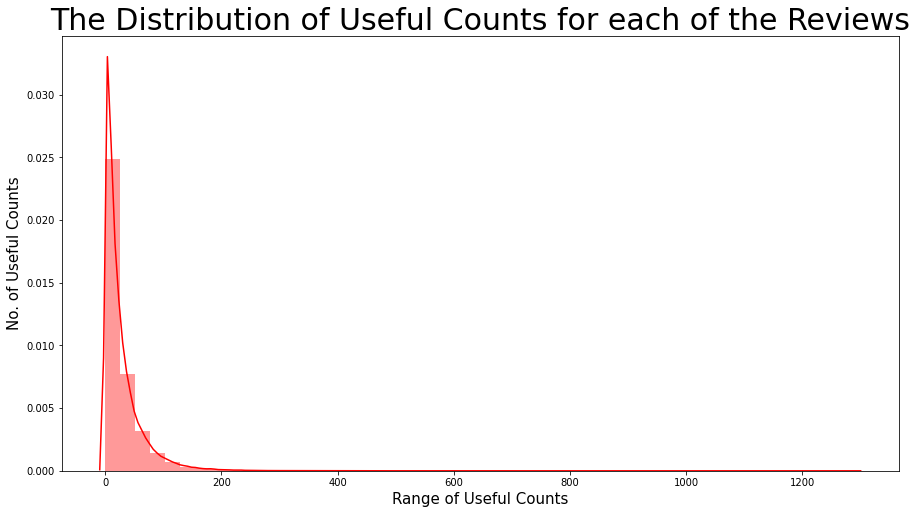

In [166]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.distplot(data['usefulCount'], color = 'red')
plt.title('The Distribution of Useful Counts for each of the Reviews', fontsize = 30)
plt.xlabel('Range of Useful Counts', fontsize = 15)
plt.ylabel('No. of Useful Counts', fontsize = 15)
plt.show()

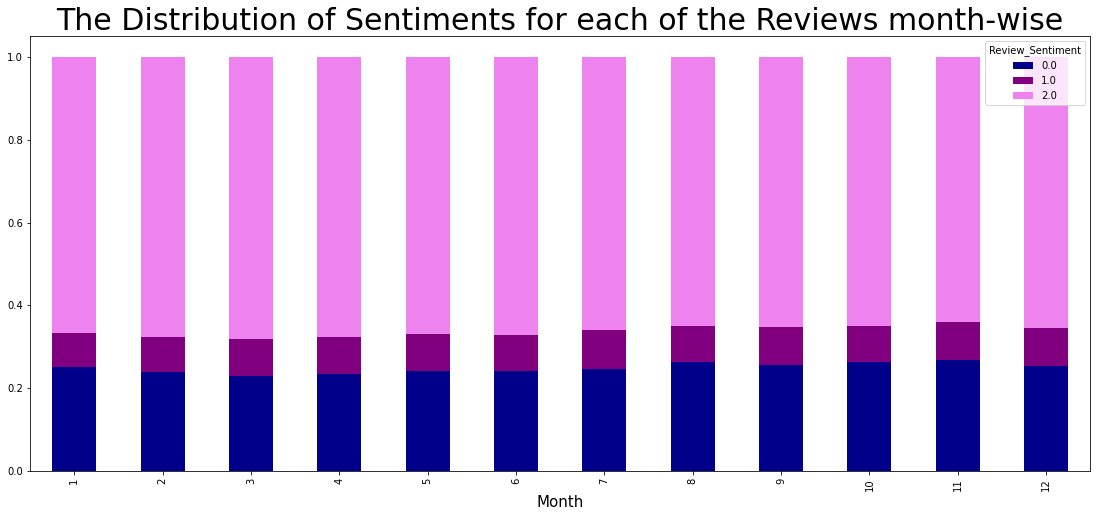

In [167]:
# plotting a stacked bar to see in which year what were the sentiments

df = pd.crosstab(data['month'] ,data['Review_Sentiment'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (19, 8), color = ['darkblue', 'purple', 'violet'])
plt.title('The Distribution of Sentiments for each of the Reviews month-wise', fontsize = 30)
plt.xlabel('Month', fontsize = 15)
plt.show()

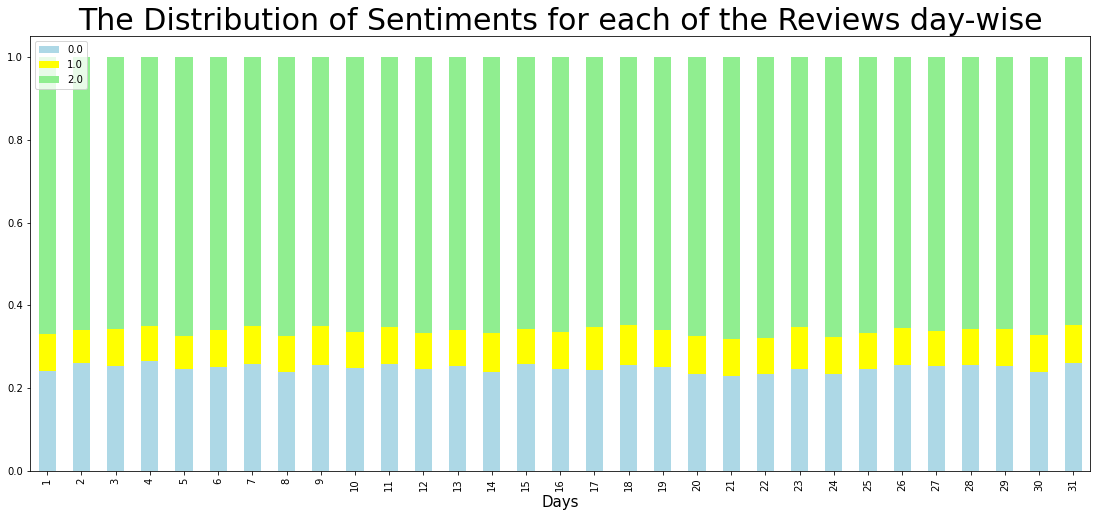

In [168]:
# plotting a stacked bar to see in which year what were the sentiments

df = pd.crosstab(data['day'] ,data['Review_Sentiment'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (19, 8), color = ['lightblue', 'yellow', 'lightgreen'])
plt.title('The Distribution of Sentiments for each of the Reviews day-wise', fontsize = 30)
plt.xlabel('Days', fontsize = 15)
plt.legend(loc = 2)
plt.show()

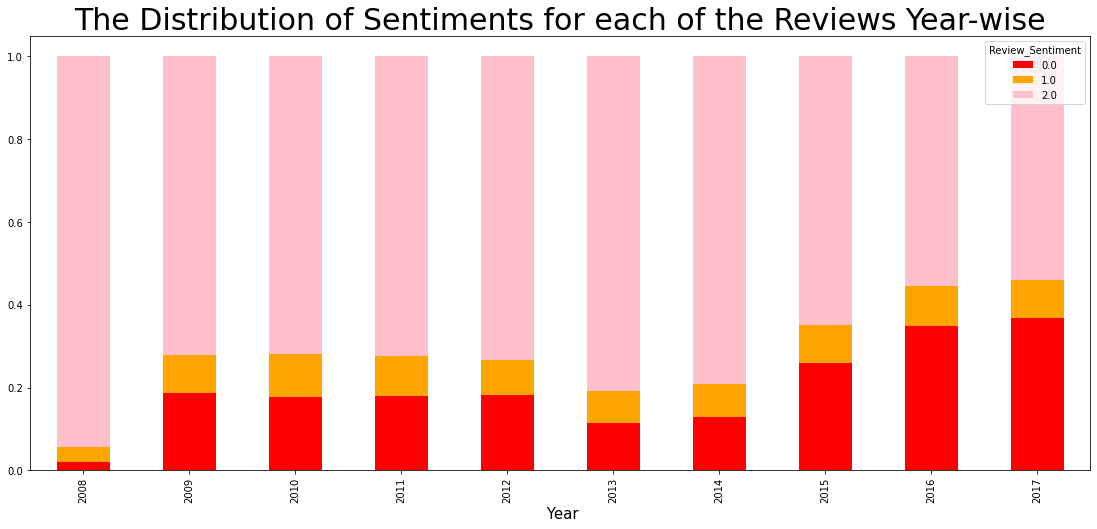

In [169]:
# plotting a stacked bar to see in which year what were the sentiments

df = pd.crosstab(data['Year'] ,data['Review_Sentiment'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (19, 8), color = ['red', 'orange', 'pink'])
plt.title('The Distribution of Sentiments for each of the Reviews Year-wise', fontsize = 30)
plt.xlabel(' Year', fontsize = 15)
plt.show()

# Preprocessing

In [176]:
data.describe()

,uniqueID,rating,usefulCount,Review_Sentiment,Year,month,day
count,215063.000000,215063.000000,215063.000000,215063.000000,215063.000000,215063.000000,215063.000000
mean,116039.364814,6.990008,28.001004,1.412595,2013.944323,6.503076,15.657282
std,67007.913366,3.275554,36.346069,0.860559,2.711913,3.421765,8.782353
min,0.000000,1.000000,0.000000,0.000000,2008.000000,1.000000,1.000000
25%,58115.500000,5.000000,6.000000,1.000000,2012.000000,4.000000,8.000000
50%,115867.000000,8.000000,16.000000,2.000000,2015.000000,7.000000,16.000000
75%,173963.500000,10.000000,36.000000,2.000000,2016.000000,9.000000,23.000000
max,232291.000000,10.000000,1291.000000,2.000000,2017.000000,12.000000,31.000000


In [177]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215063 entries, 0 to 53765
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   uniqueID          215063 non-null  int64         
 1   drugName          215063 non-null  object        
 2   condition         213869 non-null  object        
 3   review            215063 non-null  object        
 4   rating            215063 non-null  int64         
 5   date              215063 non-null  datetime64[ns]
 6   usefulCount       215063 non-null  int64         
 7   Review_Sentiment  215063 non-null  float64       
 8   Year              215063 non-null  int64         
 9   month             215063 non-null  int64         
 10  day               215063 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 24.7+ MB


Check for null values

In [178]:
data.isnull().any()

uniqueID            False
drugName            False
condition            True
review              False
rating              False
date                False
usefulCount         False
Review_Sentiment    False
Year                False
month               False
day                 False
dtype: bool

In [179]:
data['condition'].isnull().sum()

1194

In [180]:
# we will delete the rows so that the data does not overfits 

data = data.dropna(axis = 0)

# checking the new shape of the data
data.shape

(213869, 11)

In [181]:
# importing the important libraries 

import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [182]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [183]:
data.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'Review_Sentiment', 'Year', 'month', 'day'],
      dtype='object')

In [184]:
df_condition = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drugName
896,Short Stature,1
897,Hemangioma,1
898,Short Stature for Age,1
899,Sleep Paralysis,1
900,Gestational Diabetes,1
901,Gastric Cance,1
902,Gallbladder Disease,1
903,Dermatitis Herpetiformis,1
904,Somatoform Pain Disorde,1
905,Esophageal Variceal Hemorrhage Prophylaxis,1


Removing medical conditions which have only one drug associated with it in the dataset

In [185]:
# setting a df with conditions with only one drug
df_condition_1 = df_condition[df_condition['drugName'] == 1].reset_index()

all_list = set(data.index)

# deleting them
condition_list = []
for i,j in enumerate(data['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)
            
new_idx = all_list.difference(set(condition_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

removing the conditions with the word "\span" in it.


In [186]:
all_list = set(data.index)
span_list = []
for i,j in enumerate(data['condition']):
    if '</span>' in j:
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
data = data.iloc[list(new_idx)].reset_index()
del data['index']

In [187]:
data.shape

(159332, 11)

# Applying data cleanup with -


1.   Removing HTML tags
2.   Removing non letters
3.   Convert all to lower case
4.   Remove stopwords
5.   Apply stemming



In [188]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 4. Stopwords 
    meaningful_words = [w for w in words if not w in stops]
    # 5. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 6. space join words
    return( ' '.join(stemming_words))

In [189]:
%time data['review_clean'] = data['review'].apply(review_to_words)

CPU times: user 1min 45s, sys: 530 ms, total: 1min 46s
Wall time: 1min 45s


Using the entire data as for test and train instead of the original breakup since all have same columns

In [190]:
df_train, df_test = train_test_split(data, test_size = 0.25, random_state = 0)

# checking the shape 
print("Shape of train:", df_train.shape)
print("Shape of test: ", df_test.shape)

Shape of train: (119499, 12)
Shape of test:  (39833, 12)


Making a bag of words using CountVectorise

In [191]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

cv = CountVectorizer(max_features = 5000, lowercase=True, binary=True)
# cv = CountVectorizer()
pipeline = Pipeline([('vect',cv)])

# df_train_features = pipeline.fit_transform(df_train['review_clean'])
# df_train_features = cv.fit_transform(df_train['review_clean']).toarray()
df_train_features = cv.fit_transform(df_train['review_clean'])
df_test_features = pipeline.fit_transform(df_test['review_clean'])

print("Performing Bag of Words - CountVectorise\n")
print("df_train_features :", df_train_features.shape)
print("df_test_features :", df_test_features.shape)

Performing Bag of Words - CountVectorise

df_train_features : (119499, 5000)
df_test_features : (39833, 5000)


In [192]:
df_train_features = df_train_features.toarray()

In [193]:
y_train = df_train['Review_Sentiment']
y_test = df_test['Review_Sentiment']

In [194]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [195]:
y_test.shape

(39833, 3)

# SVM

In [ ]:
svmClassifier = SVC(kernel="linear", class_weight="balanced", C=0.003)
t0 = time.time()

svmClassifier.fit(df_train_features, y_train)
t1 = time.time()

svmPredictions = svmClassifier.predict(df_test_features)
t2 = time.time()

time_linear_train = t1-t0
time_linear_predict = t2-t1

# results
print("Training time: %fs; Prediction time: %fs" % (time_linear_train, time_linear_predict))
report = classification_report(y_test, svmPredictions, output_dict=True)
print('0.0: ', report['0.0'])
print('1.0: ', report['1.0'])
print('accuracy: ', report['accuracy'])
print('macro avg: ', report['macro avg'])
print('weighted avg: ', report['weighted avg'])

# Deep Learning Model

In [ ]:
# import keras 
# from keras.models import Sequential, Model
# from keras.layers import Dense, Input
# from keras.layers import Activation
# from keras.layers import Dropout
# from keras.layers import Bidirectional
# from keras.layers import BatchNormalization
# from keras.layers import LSTM
# from keras.preprocessing.sequence import pad_sequences

In [ ]:
# making our dependent variable
solution = y_test.copy()

# Model Structure
model = Sequential()
model.add(Input(shape=(df_train_features.shape[1],)))
model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(300))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(100, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#  Model compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# inputs = Input(shape=(df_train_features.shape[1],), sparse=True)
# L1 = (Dense(200))(inputs)
# L1_N = (BatchNormalization())(L1)
# L1_Act = (Activation('relu'))(L1_N)
# L1_Drop = (Dropout(0.5))(L1_Act)
# L2 = (Dense(200))(L1_Drop)
# L2_N = (BatchNormalization())(L2)
# L2_Act = (Activation('relu'))(L2_N)
# L2_Drop = Dropout(0.5)(L2_Act)
# L3 = (Dense(100, activation = 'relu'))(L2_Drop)
# outputs = (Dense(1, activation = 'sigmoid'))(L3)
# model = Model(inputs=inputs, outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
print(df_train_features)

In [ ]:
df_train['review_clean']

In [ ]:
def batch_generator(X, y, batch_size):
    number_of_batches = X.shape[0]/batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter < number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [ ]:
# 4. Train model
hist = model.fit(df_train_features, y_train, epochs=10, batch_size=64)
# steps = 10
# for i in range(steps):
#   print(model.train_on_batch(df_train_features, y_train, ))
# print(model.metrics_names)
# batch_size = 64
# nb_epoch = 5
# model.fit_generator(generator=batch_generator(df_train_features, y_train, batch_size),
#                     epochs=nb_epoch)
# 5. Traing process
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
y_pred = model.predict(df_test_features.toarray())

In [ ]:
print(accuracy_score(y_test, y_pred))

# Deep Learning Model 2

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (KerasLayer)           (None, 128)               124642688 
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              132096    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024)              0         
_________________________________________________________________
output (Dense)               (None, 2)                 2050      
Total params: 124,776,834
Trainable params: 134,146
Non-trainable params: 124,642,688
_________________________________________________________________
Epoch 1/50
934/934 [==============================] - 5s 5ms/step - loss: 0.3126 - accuracy: 0.9070
Epoch 2/50
934/934 [==============================] - 6s 6ms/step - loss: 0.2875 - accuracy: 0.9123
Epoch 3/50
934/934 [============

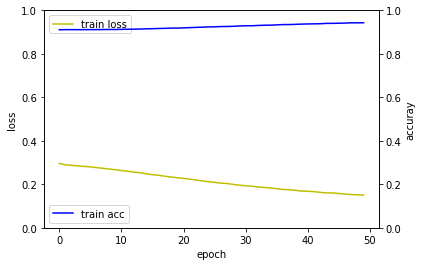

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.cluster import KMeansClusterer
import nltk
import tensorflow_hub as hub
import tensorflow as tf
from numpy.random import seed
hub_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", output_shape=[50], 
                           input_shape=[], dtype=tf.string, name='input', trainable=False)
np.random.seed(1)
model = Sequential()
model.add(hub_layer)
model.add(Dense(units=1024, activation='relu', input_dim=df_train_features.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax', name='output'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
hist = model.fit(df_train['review_clean'], y_train, epochs=50, batch_size=128)

%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.set_ylim([0.0, 1.0])
acc_ax.set_ylim([0.0, 1.0])

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
y_pred = model.predict(df_test['review_clean'])

In [ ]:
y_pred = (y_pred > 0.5) 

In [ ]:
print(accuracy_score(y_test,y_pred))

0.921740004018485


# Random Forest

In [ ]:
start = time.time()
rfc = RandomForestClassifier(n_estimators=150, random_state=42, max_depth = 1000)
rfc.fit(df_train_features, df_train['Review_Sentiment'])
end = time.time()
print("Training time: %s" % str(end-start))

# Evaluates model on test set
pred = rfc.predict(df_test_features)

print("Accuracy: %s" % str(rfc.score(df_test_features, df_test['Review_Sentiment'])))


# Bayes Classification

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
start = time.time()
multiNB = MultinomialNB().fit(df_train_features, df_train['Review_Sentiment'])
end = time.time()
print("Training time: %s" % str(end-start))

# Evaluates model on test set
pred = multiNB.predict(df_test_features)

print("Accuracy: %s" % str(multiNB.score(df_test_features, df_test['Review_Sentiment'])))

# Using LGMB Classifier

Under this section the following has been implemented -


1.   LGBM classifier trained on X = useful_count . Remarks - Just useful_count does not help in giving good predictions. Accuracy of 66.201% 
2.   Implemented sentiment prediction via TextBlob on cleaned/processed reviews. *Remarks* - It gives low correaltion with rating and review_sentiment. It should show strong correlation.
3. Implemented sentiment prediction via TextBlob on raw/unprocessed reviews. *Remarks* - It gives better correlation with rating and review_sentiment as compared to processed reviews.
4. Implemented feature engineering and calculated various nuances of the data for exploration to see what importance/effect they have on the predictions.
5. Trained LGBM classifer on the new columns(not using the review column) made using feature engineering to predict the review sentiment. *Remarks* - We see that the data obtained is a good representation of the revies column itself. It gives a high accuracy of 79.235%
6. Found the feature importance of the newly made features.


In [196]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix

#folds = KFold(n_splits=5, shuffle=True, random_state=546789)
target = df_train['Review_Sentiment']
feats = ['usefulCount']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
        
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100  #30
    )

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.787239	valid_1's multi_logloss: 0.795276
[200]	training's multi_logloss: 0.786688	valid_1's multi_logloss: 0.795441
Early stopping, best iteration is:
[102]	training's multi_logloss: 0.787219	valid_1's multi_logloss: 0.795271


In [197]:
solution = df_test['Review_Sentiment']
print("Accuracy: %s" % str(accuracy_score(solution, sub_preds)))
print(confusion_matrix(y_pred = sub_preds, y_true = solution))

Accuracy: 0.6582732909898827
[[    0     0 10001]
 [    0     0  3611]
 [    0     0 26221]]


**TextBlob** - TextBlob is a python library and offers a simple API to access its methods and perform basic NLP tasks. It performs all tasks like stemming, lemming, tokenisation etc. 

The sentiment function of textblob returns two properties, polarity, and subjectivity.
Polarity is float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgment whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1].

**tqdm** - It basically is a loader/progress bar which tells how data has been processed/what is the progress. 

In [198]:
from textblob import TextBlob
from tqdm import tqdm
reviews = data['review_clean']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
data["Predict_Sentiment"] = Predict_Sentiment
data.head()

100%|██████████| 159332/159332 [00:48<00:00, 3262.34it/s]


,uniqueID,drugName,condition,review,rating,date,usefulCount,Review_Sentiment,Year,month,day,review_clean,Predict_Sentiment
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,2.0,2012,5,20,no side effect take combin bystol mg fish oil,0.000000
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,2.0,2010,4,27,son halfway fourth week intuniv becam concern ...,0.114583
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,1.0,2009,12,14,use take anoth oral contracept pill cycl happi...,0.105000
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,2.0,2015,11,3,first time use form birth control glad went pa...,0.300000
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,2.0,2016,11,27,suboxon complet turn life around feel healthie...,0.147037


checking the correlation coef between predict sentiment and rating

In [199]:
np.corrcoef(data["Predict_Sentiment"], data["rating"])

array([[1.        , 0.25713182],
       [0.25713182, 1.        ]])

checking the correlation coef between predict sentiment and sentiment

In [200]:
np.corrcoef(data["Predict_Sentiment"], data["Review_Sentiment"])

array([[1.        , 0.24306945],
       [0.24306945, 1.        ]])

Predicting sentiment on raw reviews(reviews without any preprocessing) to check of there is better correalation between the predicted sentiment and ratings and review_sentiment

In [201]:
reviews = data['review']

Predict_Sentiment = []
for review in tqdm(reviews):
    blob = TextBlob(review)
    Predict_Sentiment += [blob.sentiment.polarity]
data["Predict_Sentiment2"] = Predict_Sentiment

100%|██████████| 159332/159332 [01:36<00:00, 1658.34it/s]


In [202]:
np.corrcoef(data["Predict_Sentiment2"], data["rating"])

array([[1.        , 0.34883859],
       [0.34883859, 1.        ]])

In [203]:
np.corrcoef(data["Predict_Sentiment2"], data["Review_Sentiment"])

array([[1.        , 0.32843284],
       [0.32843284, 1.        ]])

Performing feature engineering

In [204]:
# word count in each unclean comment
data['count_sent'] = data["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

# Word count in each comment:
data['count_word'] = data["review_clean"].apply(lambda x: len(str(x).split()))

# Unique word count
data['count_unique_word'] = data["review_clean"].apply(lambda x: len(set(str(x).split())))

# Letter count
data['count_letters'] = data["review_clean"].apply(lambda x: len(str(x)))

# punctuation count
import string
data["count_punctuations"] = data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# upper case words count
data["count_words_upper"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

# title case words count
data["count_words_title"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

# Number of stopwords
data["count_stopwords"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in stops]))

# Average length of the words
data["mean_word_len"] = data["review_clean"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# adding season
data['season'] = data["month"].apply(lambda x: 1 if ((x>2) & (x<6)) else(2 if (x>5) & (x<9) else (3 if (x>8) & (x<12) else 4)))

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


In [205]:
len_train = df_train.shape[0]
print(len_train)

119499


In [206]:
df_train = data[:len_train]
df_test = data[len_train:]

df_train.columns

Index(['uniqueID', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount', 'Review_Sentiment', 'Year', 'month', 'day',
       'review_clean', 'Predict_Sentiment', 'Predict_Sentiment2', 'count_sent',
       'count_word', 'count_unique_word', 'count_letters',
       'count_punctuations', 'count_words_upper', 'count_words_title',
       'count_stopwords', 'mean_word_len', 'season'],
      dtype='object')

Training LGBM Classifier on all the features other than the review_clean, to get how all the other features affect the prediction.

In [207]:
target = df_train['Review_Sentiment']

feats = ['usefulCount','day','Year','month','Predict_Sentiment','Predict_Sentiment2', 'count_sent',
          'count_word', 'count_unique_word', 'count_letters', 'count_punctuations',
          'count_words_upper', 'count_words_title', 'count_stopwords', 'mean_word_len', 'season']

sub_preds = np.zeros(df_test.shape[0])

trn_x, val_x, trn_y, val_y = train_test_split(df_train[feats], target, test_size=0.2, random_state=42) 
feature_importance_df = pd.DataFrame() 
    
clf = LGBMClassifier(
        n_estimators=10000,
        learning_rate=0.10,
        num_leaves=30,
        #colsample_bytree=.9,
        subsample=.9,
        max_depth=7,
        reg_alpha=.1,
        reg_lambda=.1,
        min_split_gain=.01,
        min_child_weight=2,
        silent=-1,
        verbose=-1,
        )
clf.fit(trn_x, trn_y, 
        eval_set= [(trn_x, trn_y), (val_x, val_y)], 
        verbose=100, early_stopping_rounds=100)

sub_preds = clf.predict(df_test[feats])
        
fold_importance_df = pd.DataFrame()
fold_importance_df["feature"] = feats
fold_importance_df["importance"] = clf.feature_importances_
feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 0.678922	valid_1's multi_logloss: 0.699039
[200]	training's multi_logloss: 0.648567	valid_1's multi_logloss: 0.691028
[300]	training's multi_logloss: 0.623173	valid_1's multi_logloss: 0.684542
[400]	training's multi_logloss: 0.59888	valid_1's multi_logloss: 0.678824
[500]	training's multi_logloss: 0.577521	valid_1's multi_logloss: 0.673486
[600]	training's multi_logloss: 0.557566	valid_1's multi_logloss: 0.668582
[700]	training's multi_logloss: 0.538661	valid_1's multi_logloss: 0.663837
[800]	training's multi_logloss: 0.52082	valid_1's multi_logloss: 0.659369
[900]	training's multi_logloss: 0.503205	valid_1's multi_logloss: 0.654383
[1000]	training's multi_logloss: 0.485884	valid_1's multi_logloss: 0.650499
[1100]	training's multi_logloss: 0.4708	valid_1's multi_logloss: 0.646732
[1200]	training's multi_logloss: 0.45523	valid_1's multi_logloss: 0.642825
[1300]	training's multi_logloss: 0.4406

In [208]:
solution = df_test['Review_Sentiment']
print("Accuracy: %s" % str(accuracy_score(solution, sub_preds)))
confusion_matrix(y_pred=sub_preds, y_true=solution)

Accuracy: 0.7923580950468204


array([[ 5768,    47,  3976],
       [  588,  1185,  1899],
       [ 1680,    81, 24609]])

Plotting the feature importance

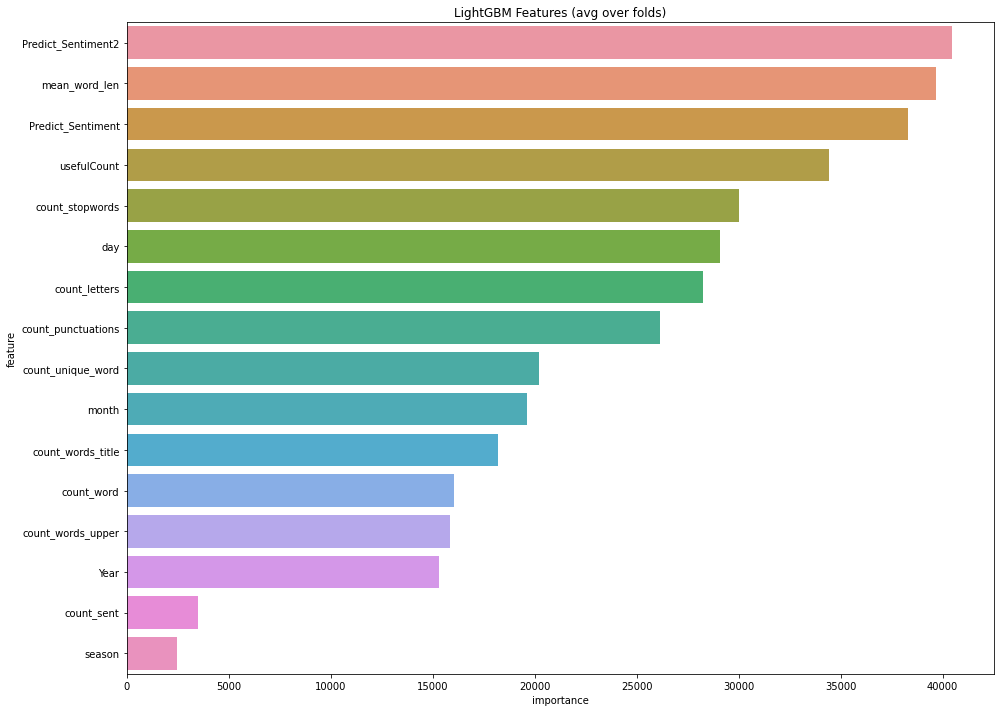

In [209]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending = False)[:50].index

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,10))
sns.barplot(x="importance", y="feature", data = best_features.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()